### Importing Set Up - using Python 3.11.5

In [22]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import ipywidgets as widgets

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

### Database Creation

This is a separate file that we wrote to take care of all of the ETL processes.

In [23]:
execfile("Setup_and_Organization/Database Setup.py")

### SQLite Database Connection

In [24]:
engine = create_engine("sqlite:///Resources/database.sqlite")
conn=engine.connect()

# reflect an existing database into a new model
base = automap_base()
# reflect the tables
# base.prepare(engine,reflect=True)

base.prepare(autoload_with=engine)

### Data File Loading and Graph Formatting

Once we have a connection to the database, we want to get the data we desire so that we can create visualizations with that data. We create one DataFrame that all visualizations can use. While all of the joins will create many columns, we're only selecting the columns that we need for the visualizations.

In [25]:
data = pd.read_sql('SELECT g.gender_name, b.bmi_name, o.occupation_name, h.stress_level, h.heart_rate, h.systolic, h.diastolic, \
            p.gender_id, s.sleep_duration, s.sleep_quality, p.age, sd.sleep_disorder_name, s.person_id\
            FROM person AS p\
            INNER JOIN sleep AS s\
            ON s.person_id = p.id\
            INNER JOIN occupation AS o\
            ON o.id = p.occupation_id\
            INNER JOIN gender AS g\
            ON p.gender_id = g.id\
            INNER JOIN sleep_disorder AS sd\
            ON sd.id = s.sleep_disorder_id\
            INNER JOIN health AS h\
            ON h.person_id = p.id\
            INNER JOIN bmi AS b\
            ON b.id = h.bmi_id',
            conn) 

sns.set_palette("Paired")
engine.dispose()

### Bryan's Visualization / Interaction

In [38]:
dd = widgets.Dropdown(
    options = {"Age": "age", "Stress Level": "stress_level", "Heart Rate": "heart_rate", "Systolic": "systolic", "Diastolic": "diastolic"},
    value = "age",
    description = "Category"
)

# genders = data["gender_name"].unique().tolist()

dd1 = widgets.Dropdown(
    options = ["All", "Male", "Female"],
    value = "All",
    description = "Gender"
)

# bmis = data["bmi_name"].unique().tolist()

dd2 = widgets.Dropdown(
    options = ["All", "Normal", "Overweight", "Obese"],
    value = "All",
    description = "BMI Type"
)

def draw_plot(column, gender, bmi):    
    
    if (gender == "All"):
        if (bmi == "All"):
            mask = (data["gender_name"].isin(["Male", "Female"])) & (data["bmi_name"].isin(["Normal", "Overweight", "Obese"]))
        else:
            mask = (data["gender_name"].isin(["Male", "Female"])) & (data["bmi_name"] == bmi)
    else:
        if (bmi == "All"):
            mask = (data["gender_name"] == gender) & (data["bmi_name"].isin(["Normal", "Overweight", "Obese"]))
        else:
            mask = (data["gender_name"] == gender) & (data["bmi_name"] == bmi)
    #sns.set_theme(style = "ticks")
    f, ax = plt.subplots(figsize = (8, 6))
    sns.boxplot(x = data.loc[mask, column],
                y = data.loc[mask, "occupation_name"], 
                hue = data["occupation_name"],
                palette = "Paired",
                width = 0.6,
                legend = False
    )
    sns.stripplot(
        x = data.loc[mask, column],
        y = data.loc[mask, "occupation_name"],
        color = "black",
        dodge = True,
        edgecolor = "black"
    )

    column_proper = column.replace("_", " ").title()
    ax.set_xlabel(column_proper, fontsize = 15)
    ax.set_ylabel("Occupation", fontsize = 15)
    plt.title(f"Distribution of {column_proper} per Occupation ({gender})", fontsize = 18)
    plt.tight_layout()
    # plt.savefig(f"Images/{column}_gender-{gender}_bmi-{bmi}.png")

ddbox = widgets.HBox([dd, dd1, dd2])
out1 = widgets.interactive_output(draw_plot, {"column": dd, "gender": dd1, "bmi": dd2})
display(ddbox, out1)

Output()

### Reed's Visualization / Interaction

In [27]:
# Create a dropdown widget to select gender
gender_dropdown = widgets.Dropdown(
    options=["All", 'Male', 'Female'],
    description='Gender:'
)
def draw_plot2(item):
    if item == "All":
        mask = data["gender_name"].isin(["Male", "Female"])
    else:
        mask = data["gender_name"] == item
    sns.relplot(x=data.loc[mask, "age"],
                y=data.loc[mask,"sleep_duration"],
                hue=data.loc[mask,"stress_level"],
                size=data.loc[mask,"sleep_quality"],
                sizes=(40, 400),
                alpha=.5,
                palette="Paired",
                height=6,
                data=data)\
            .set(title= "Sleep Duration vs Age")
out1= widgets.interactive_output(draw_plot2,{"item":gender_dropdown})
display(gender_dropdown,out1)

Dropdown(description='Gender:', options=('All', 'Male', 'Female'), value='All')

Output()

### Andrew's Visualization / Interaction

In [39]:
means_by_occupation = data.groupby(['occupation_name', 'sleep_disorder_name']).agg({'sleep_duration': 'mean', 'sleep_quality': 'mean'})

means_by_occupation

sleep_duration  sleep_quality
occupation_name      sleep_disorder_name                               
Accountant           Insomnia                   6.657143       7.142857
                     None                       7.220000       8.066667
Doctor               Insomnia                   6.866667       6.666667
                     None                       6.943750       6.578125
                     Sleep Apnea                7.475000       7.750000
Engineer             Insomnia                   7.440000       7.400000
                     None                       8.038596       8.508772
                     Sleep Apnea                7.800000       8.000000
Lawyer               Insomnia                   7.400000       8.000000
                     None                       7.419048       7.928571
                     Sleep Apnea                7.300000       7.333333
Manager              None                       6.900000       7.000000
Nurse                Insomnia                   6.333333       5.333333
                     None                       7.222222       7.555556
                     Sleep Apnea                7.075410       7.442623
Sales Representative Sleep Apnea                5.900000       4.000000
Salesperson          Insomnia                   6.396552       6.000000
                     None                       6.450000       6.000000
                     Sleep Apnea                6.500000       6.000000
Scientist            None                       6.200000       6.000000
                     Sleep Apnea                5.800000       4.000000
Software Engineer    Insomnia                   5.900000       4.000000
                     None                       7.033333       7.333333
Teacher              Insomnia                   6.585185       6.888889
                     None                       6.933333       7.555556
                     Sleep Apnea                6.850000       6.250000

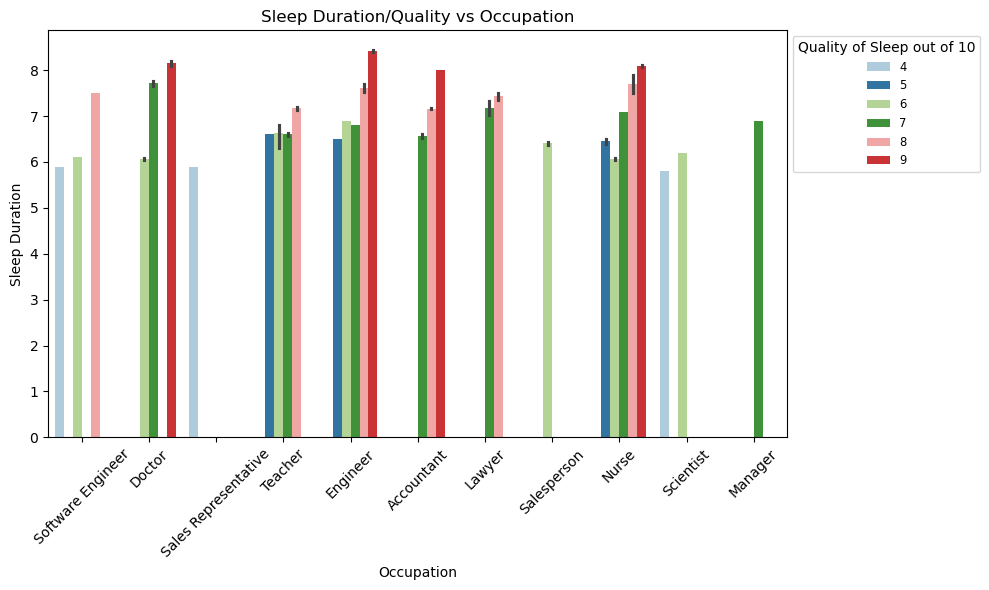

In [29]:
# 1. Sleep Duration/Quality vs Occupation
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=data, x='occupation_name', y='sleep_duration', hue='sleep_quality', palette="Paired")
plt.title('Sleep Duration/Quality vs Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration')
# Rotate the job titles by 45 degrees
plt.xticks(rotation=45)
# Customize legend labels as numbers from 0 to 10 and legend title
legend_labels = [f'{label}/10' for label in range(11)]
legend_title = 'Quality of Sleep out of 10'
legend = plt.legend(title=legend_title, loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
if len(legend_labels) == len(legend.get_texts()):
    for i, text in enumerate(legend_labels):
        legend.get_texts()[i].set_text(text)
plt.tight_layout()

In [30]:
# Calculate the mean stress level per occupation
mean_stress_per_occupation = data.groupby('occupation_name')['stress_level'].mean()

# Display the mean stress level per occupation
mean_stress_per_occupation

occupation_name
Accountant              4.594595
Doctor                  6.732394
Engineer                3.888889
Lawyer                  5.063830
Manager                 5.000000
Nurse                   5.547945
Sales Representative    8.000000
Salesperson             7.000000
Scientist               7.000000
Software Engineer       6.000000
Teacher                 4.525000
Name: stress_level, dtype: float64

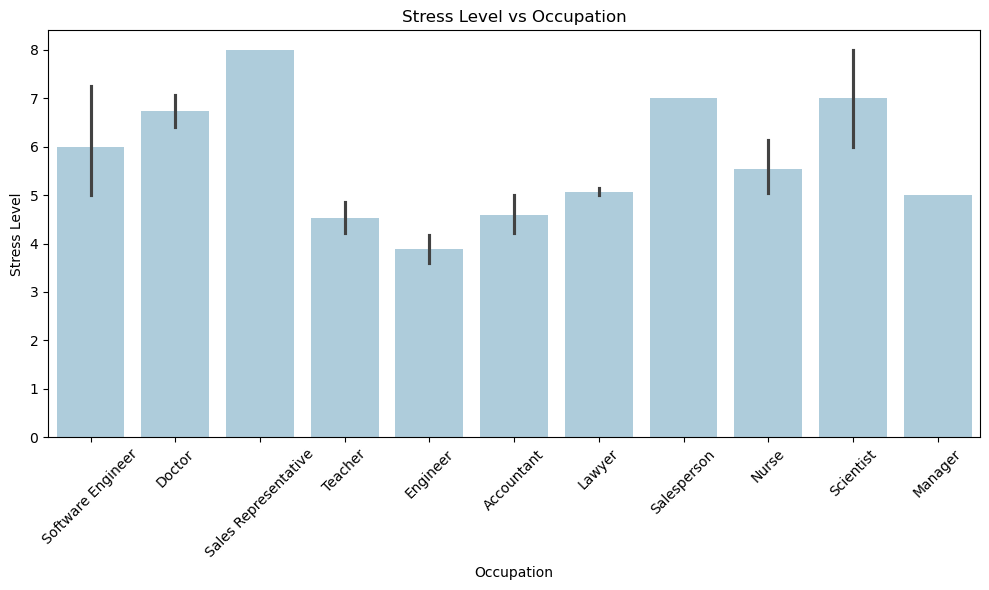

In [31]:
# 6. Stress Level vs Occupation
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='occupation_name', y='stress_level')
plt.title('Stress Level vs Occupation')
plt.xlabel('Occupation')
plt.ylabel('Stress Level')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [32]:
# Calculate the mean sleep duration and quality per occupation
mean_sleep_duration = data.groupby('occupation_name')['sleep_duration'].mean()
mean_sleep_quality = data.groupby('occupation_name')['sleep_quality'].mean()

# Display the mean sleep duration per occupation
print("Mean Sleep Duration per Occupation:")
print(mean_sleep_duration)

# Display the mean sleep quality per occupation
print("\nMean Sleep Quality per Occupation:")
print(mean_sleep_quality)

Mean Sleep Duration per Occupation:
occupation_name
Accountant              7.113514
Doctor                  6.970423
Engineer                7.987302
Lawyer                  7.410638
Manager                 6.900000
Nurse                   7.063014
Sales Representative    5.900000
Salesperson             6.403125
Scientist               6.000000
Software Engineer       6.750000
Teacher                 6.690000
Name: sleep_duration, dtype: float64

Mean Sleep Quality per Occupation:
occupation_name
Accountant              7.891892
Doctor                  6.647887
Engineer                8.412698
Lawyer                  7.893617
Manager                 7.000000
Nurse                   7.369863
Sales Representative    4.000000
Salesperson             6.000000
Scientist               5.000000
Software Engineer       6.500000
Teacher                 6.975000
Name: sleep_quality, dtype: float64


In [33]:
mean_sleep_duration_per_disorder = data.groupby('sleep_disorder_name')['sleep_duration'].mean()
mean_sleep_quality_per_disorder = data.groupby('sleep_disorder_name')['sleep_quality'].mean()

# Display the mean sleep duration per disorder
print("Mean Sleep Duration per Disorder:")
print(mean_sleep_duration_per_disorder)

# Display the mean sleep quality per disorder
print("\nMean Sleep Quality per Disorder:")
print(mean_sleep_quality_per_disorder)

Mean Sleep Duration per Disorder:
sleep_disorder_name
Insomnia       6.589610
None           7.358447
Sleep Apnea    7.032051
Name: sleep_duration, dtype: float64

Mean Sleep Quality per Disorder:
sleep_disorder_name
Insomnia       6.532468
None           7.625571
Sleep Apnea    7.205128
Name: sleep_quality, dtype: float64


In [34]:
# Sleep Duration/Quality vs Occupation

# Dropdown for selecting Sleep Quality or Sleep Duration
dd_metric = widgets.Dropdown(
    options=['Sleep Quality', 'Sleep Duration'],
    value='Sleep Quality',
    description='Metric:'
)

def plot_charts1(metric):
    if metric == 'Sleep Quality':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='occupation_name', y='sleep_quality', hue='sleep_disorder_name', palette= "Paired")
        plt.title('Quality of Sleep vs Occupation')
        plt.xlabel('Occupation')
        plt.ylabel('Quality of Sleep')
        plt.xticks(rotation=45)
        legend = plt.legend(title='Sleep Disorder', loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
        legend.set_title('Sleep Disorder', prop={'size': 'small'})
        plt.tight_layout()
        plt.show()
    elif metric == 'Sleep Duration':
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='occupation_name', y='sleep_duration', hue='sleep_disorder_name', palette= "Paired")
        plt.title('Sleep Duration vs Occupation')
        plt.xlabel('Occupation')
        plt.ylabel('Sleep Duration')
        plt.xticks(rotation=45)
        legend = plt.legend(title='Sleep Disorder', loc='upper left', fontsize='small', bbox_to_anchor=(1, 1))
        legend.set_title('Sleep Disorder', prop={'size': 'small'})
        plt.tight_layout()
        plt.show()

def plot_charts2(metric):
    if metric == 'Sleep Quality':
        # Quality of Sleep vs Sleep Disorder
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='sleep_disorder_name', y='sleep_quality', hue= "sleep_disorder_name", palette= "Paired")
        plt.title('Quality of Sleep vs Sleep Disorder')
        plt.xlabel('Sleep Disorder')
        plt.ylabel('Quality of Sleep')
        plt.xticks(rotation=45)
        plt.tight_layout()
    elif metric == 'Sleep Duration':
        # Sleep Duration/Quality vs Sleep Disorder
        plt.figure(figsize=(10, 6))
        sns.barplot(data=data, x='sleep_disorder_name', y='sleep_duration', hue = "sleep_disorder_name", palette= "Paired")
        plt.title('Sleep Duration vs Sleep Disorder')
        plt.xlabel('Sleep Disorder')
        plt.ylabel('Sleep Duration')
        plt.xticks(rotation=45)
        plt.tight_layout()


# Interactive output for the plot
out_metric1 = widgets.interactive_output(plot_charts1, {'metric': dd_metric})

out_metric2 = widgets.interactive_output(plot_charts2, {"metric": dd_metric})

out_metric = widgets.HBox([out_metric1, out_metric2])


# Display dropdown and output
display(dd_metric, out_metric)

Dropdown(description='Metric:', options=('Sleep Quality', 'Sleep Duration'), value='Sleep Quality')

In [35]:
df = data.copy()

dd_gender = widgets.Dropdown(
    options=["Male", "Female"],
    value="Male",
    description="Gender"
)

dd_age = widgets.Dropdown(
    options=["20-29", "30-39", "40-49"],
    value="20-29",
    description="Age Group"
)

dd_column = widgets.Dropdown(
    options={"Sleep Duration": "sleep_duration", "Sleep Quality": "sleep_quality"},
    value="sleep_duration",
    description="Sleep Type"
)

def plot_barcharts(gender, age, column):
    data_filtered = df.loc[(df["gender_name"] == gender) & (df["age"] // 10 * 10 == int(age.split("-")[0]))]
    
    if data_filtered.empty:
        print("No data available for the selected gender and age group.")
        return
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=data_filtered, x="age", y=column)
    plt.title(f'{gender} {age} vs {column.replace("_", " ").title()}')
    plt.xlabel('Age')
    plt.ylabel(column.replace("_", " ").title())
    plt.tight_layout()

ddbox = widgets.HBox([dd_gender, dd_age, dd_column])

out = widgets.interactive_output(plot_barcharts, {"gender": dd_gender, "age": dd_age, "column": dd_column})

display(ddbox, out)

Output()

### Health Factors By Gender

In [36]:
health_metrics = data[['person_id','heart_rate','systolic','diastolic','gender_name']]

genderBox = widgets.Dropdown(
    options = ['Male & Female','Male', 'Female'], #'Male & Female',
    value = 'Male & Female',
    description = 'Gender'
)
def health_plot(gender):
    if (gender == 'Male & Female'): #total population
        mask = (health_metrics['gender_name'].isin(['Male', 'Female']))
    else: # male or female
        mask = (health_metrics['gender_name'] == gender)
    h_diag = sns.PairGrid(data=health_metrics.loc[mask,['person_id','heart_rate','systolic','diastolic']])
    h_diag.map_diag(sns.histplot)
    h_diag.map_offdiag(sns.scatterplot)
    #plt.show()
outh = widgets.interactive_output(health_plot, {'gender': genderBox})
display(genderBox, outh)

Dropdown(description='Gender', options=('Male & Female', 'Male', 'Female'), value='Male & Female')

Output()